[**RUN CODE**](https://colab.research.google.com/drive/1e3EDYZHBXAp3qAGypDQyXN6BuYLUGYxu?usp=sharing)

# Import Libraries

In [ ]:
!pip install -q category_encoders

In [ ]:
!pip install -q shap

In [ ]:
!pip install -q optuna

In [ ]:
!pip install -q catboost

In [ ]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder

from sklearn.feature_selection import SelectFromModel


from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



import optuna


import tqdm
import joblib
import pickle
# serializd your object and svaes its binary form 

import shap


pd.set_option('display.max_columns', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

style.use('ggplot')
sns.set_palette('Set2')
# blue, orange, green

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train_dataset_site.csv')
test = pd.read_csv('https://raw.githubusercontent.com/vaasu2002/PROJECTS/main/Machine%20Learning/Site%20Energy%20Use%20Prediction/DATASET/x_test.csv')

In [ ]:
df_train = train.copy()
df_test = test.copy()

In [ ]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [ ]:
train

Year_Factor State_Factor building_class  \
0                1      State_1     Commercial   
1                1      State_1     Commercial   
2                1      State_1     Commercial   
3                1      State_1     Commercial   
4                1      State_1     Commercial   
...            ...          ...            ...   
75752            6     State_11     Commercial   
75753            6     State_11    Residential   
75754            6     State_11     Commercial   
75755            6     State_11     Commercial   
75756            6     State_11    Residential   

                                   facility_type  floor_area  year_built  \
0                   Grocery_store_or_food_market     61242.0      1942.0   
1      Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                           Retail_Enclosed_mall    280025.0      1951.0   
3                      Education_Other_classroom     55325.0      1980.0   
4                      Warehouse_Nonrefrigerated     66000.0      1985.0   
...                                          ...         ...         ...   
75752                       Office_Uncategorized     20410.0      1995.0   
75753                        5plus_Unit_Building     40489.0      1910.0   
75754                           Commercial_Other     28072.0      1917.0   
75755                           Commercial_Other     53575.0      2012.0   
75756                         2to4_Unit_Building     23888.0      1974.0   

       energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  \
0                    11.0        2.4                36         50.500000   
1                    45.0        1.8                36         50.500000   
2                    97.0        1.8                36         50.500000   
3                    46.0        1.8                36         50.500000   
4                   100.0        2.4                36         50.500000   
...                   ...        ...               ...               ...   
75752                 8.0       36.6                28         43.451613   
75753                98.0       36.6                28         43.451613   
75754                 NaN       36.6                26         36.612903   
75755                 NaN       36.6                26         36.612903   
75756                51.0       36.6                27         36.935484   

       january_max_temp  february_min_temp  february_avg_temp  \
0                    68                 35          50.589286   
1                    68                 35          50.589286   
2                    68                 35          50.589286   
3                    68                 35          50.589286   
4                    68                 35          50.589286   
...                 ...                ...                ...   
75752                56                 34          47.672414   
75753                56                 34          47.672414   
75754                48                 30          41.637931   
75755                48                 30          41.637931   
75756                51                 29          42.172414   

       february_max_temp  march_min_temp  march_avg_temp  march_max_temp  \
0                     73              40       53.693548              80   
1                     73              40       53.693548              80   
2                     73              40       53.693548              80   
3                     73              40       53.693548              80   
4                     73              40       53.693548              80   
...                  ...             ...             ...             ...   
75752                 64              35       49.354839              71   
75753                 64              35       49.354839              71   
75754                 58              29       41.338710              62   
75755                 58              2

In [ ]:
df_train.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

df_test.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

# df.columns = df.columns.values.lower()

# EDA

## Understanding features

**year_Factor**: anonymized year in which the weather and energy usage factors were observed  

**state_Factor**: anonymized state in which the building is located  

**building_class**: building classification  

**facility_type**: building usage type  

**floor_area**: floor area (in square feet) of the building  

**year_built**: year in which the building was constructed  

**energy_star_rating**: the energy star rating of the building  

**elevation**: elevation of the building location  

**january_min_temp**: minimum temperature in January (in Fahrenheit) at the location of the building  

**january_avg_temp**: average temperature in January (in Fahrenheit) at the location of the building  

**january_max_temp**: maximum temperature in January (in Fahrenheit) at the location of the building  

[Similarly for all other months]

**cooling_degree_days**: cooling degree day for a given day is the number of degrees where the daily average temperature   
exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

**heating_degree_days**: heating degree day for a given day is the number of degrees where the daily average temperature   falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

**precipitation_inches**: annual precipitation in inches at the location of the building  

**snowfall_inches**: annual snowfall in inches at the location of the building  

**snowdepth_inches**: annual snow depth in inches at the location of the building  

**avg_temp**: average temperature over a year at the location of the building  

**days_below_30F**: total number of days below 30 degrees Fahrenheit at the location of the building  

**days_below_20F**: total number of days below 20 degrees Fahrenheit at the location of the building  

**days_below_10F**: total number of days below 10 degrees Fahrenheit at the location of the building  

**days_below_0F**: total number of days below 0 degrees Fahrenheit at the location of the building  

**days_above_80F**: total number of days above 80 degrees Fahrenheit at the location of the building  

**days_above_90F**: total number of days above 90 degrees Fahrenheit at the location of the building  

**days_above_100F**: total number of days above 100 degrees Fahrenheit at the location of the building  

**days_above_110F**: total number of days above 110 degrees Fahrenheit at the location of the building  

**direction_max_wind_speed**: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

**direction_peak_wind_speed**: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

**max_wind_speed**: maximum wind speed at the location of the building  

**days_with_fog**: number of days with fog at the location of the building  

**building_id**: building id  

### Target
**site_eui**: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills  

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_factor                75757 non-null  int64  
 1   state_factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   elevation                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [ ]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [ ]:
print([col for col in df_train if df_train[col].nunique()==1])
print([col for col in df_test if df_test[col].nunique()==1])

[]
['year_factor', 'days_above_110F']


In [ ]:
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [ ]:
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
# Missing values for training data
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


In [ ]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
# Missing values for test data
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


In [ ]:
df_test[['year_factor', 'days_above_110F']]

year_factor  days_above_110F
0               7                0
1               7                0
2               7                0
3               7                0
4               7                0
...           ...              ...
9700            7                0
9701            7                0
9702            7                0
9703            7                0
9704            7                0

[9705 rows x 2 columns]

### Observations:   
   
1) `year_built`, `energy_star_rating`, `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, `days_with_fog` variables have `NA` values.   
2) Data contains 75757 samples and 64 features. We have 3 categorical and rest numerical features. Target is numerical.   
3) There are no duplicates in individual dataset, however there might be duplicates in the combined version   
4) there are no constant columns in train dataset, but test dataset has 2 constant columns   

### combine the datasets for the visualizations

In [ ]:
test['site_eui'] = np.nan #63
test['dataset'] = 'test'
train['dataset'] = 'train'


df_all = pd.concat([train, test], axis=0, ignore_index=True)

The dataset contains time variable, `Year_Factor`, that has values from 1 to 7. Assuming the values are consecutive years,`train` dataset contains the first 6 years and `test` set contains the 7th year.

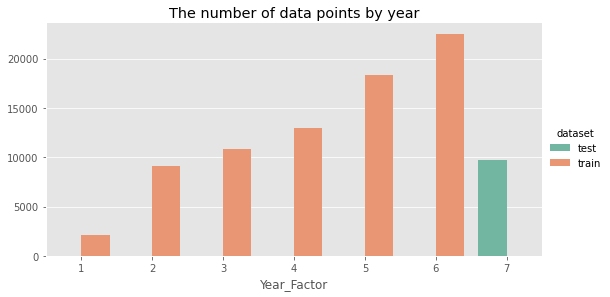

In [ ]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

`train` set contains data points of 7 states, however, `test` doesn't have any data point from `State_6`.

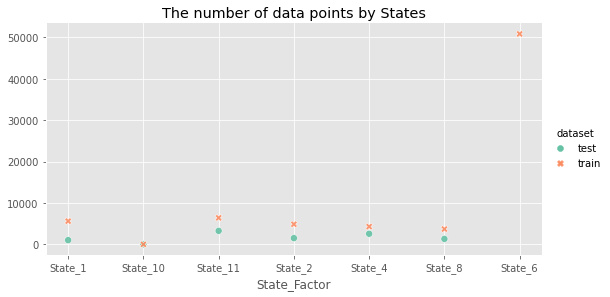

In [ ]:
ax = sns.relplot(x='State_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by States",
    ylabel=None)

Both residential and commercial buildings are present in both datasets. `train` data contains more residential buildings compared to `test` set which is due to the number of`State_6` buildings in `train` set which seems to add to the number. Apart from `State_6`, the number of commercial buildings are higher than the residential buildings and `State_10` only contains commercial buildings. The type of building and state could be important factors in determining `EUI`.

Text(0.5, 0, '')

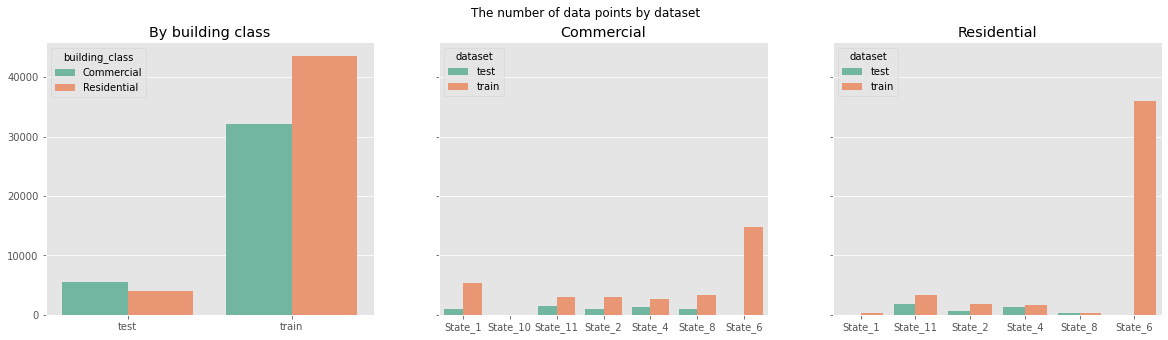

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

All facility types are present in both datasets. Almost 90% of residential `Multifamily_uncategorized` buildings and 50% of `Office_uncategorized` are in `State_6` of the training set. Not quite sure how `State_6` will affect the model learning and prediction.

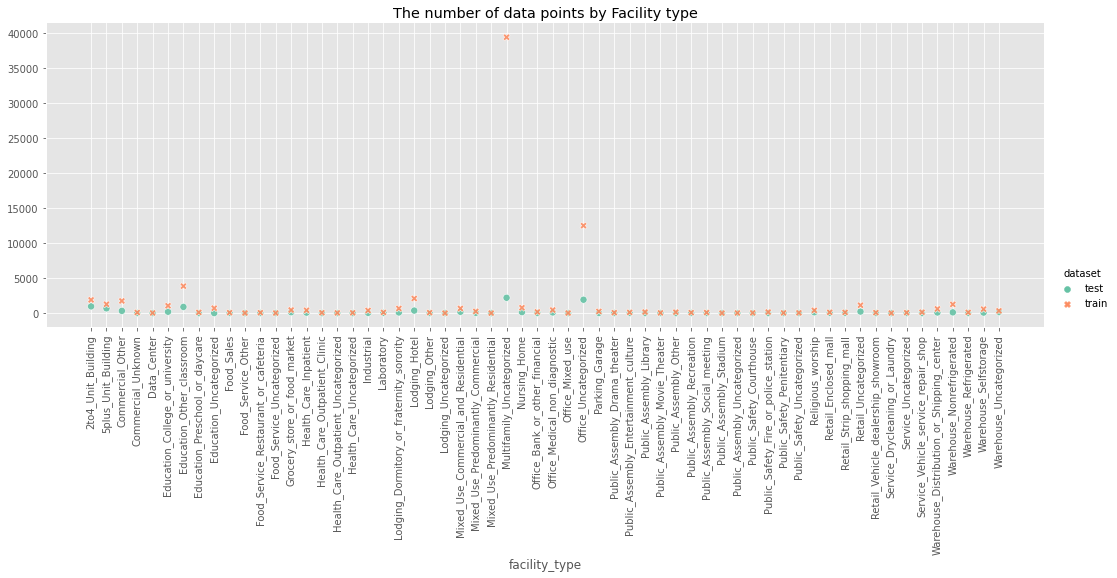

In [ ]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

The oldest building was built in 1600 and the latest in 2016. The majority of the buildings were built since 1900. There were some 0 and null values. Not quite sure what 0 signifies.

In [ ]:
df_all['year_built'].value_counts().index.sort_values()

Float64Index([   0.0, 1600.0, 1649.0, 1732.0, 1756.0, 1789.0, 1799.0, 1800.0,
              1811.0, 1815.0,
              ...
              2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
              2015.0, 2016.0],
             dtype='float64', length=183)

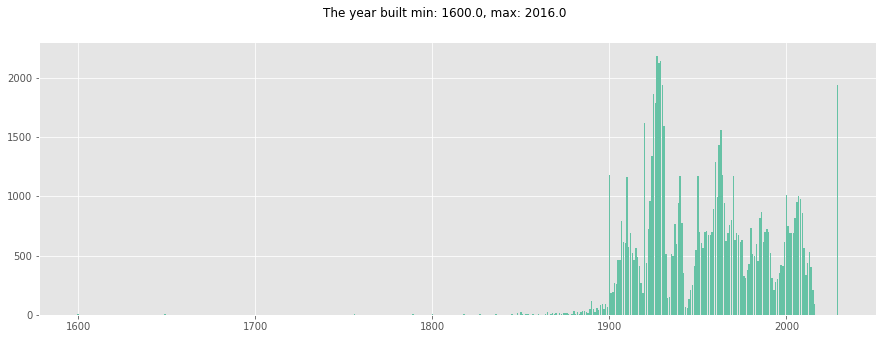

In [ ]:
temp = df_all[['year_built']].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)\
            .sort_values('year_built')
# temp['year_built'] = temp['year_built'].astype('category')
fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['year_built'],
           temp['count']
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}");

`train` set buildings have higher floor areas compared to `test` set buildings and small positive correlation between `floor_area` and `energy_star_rating` can be observable. 

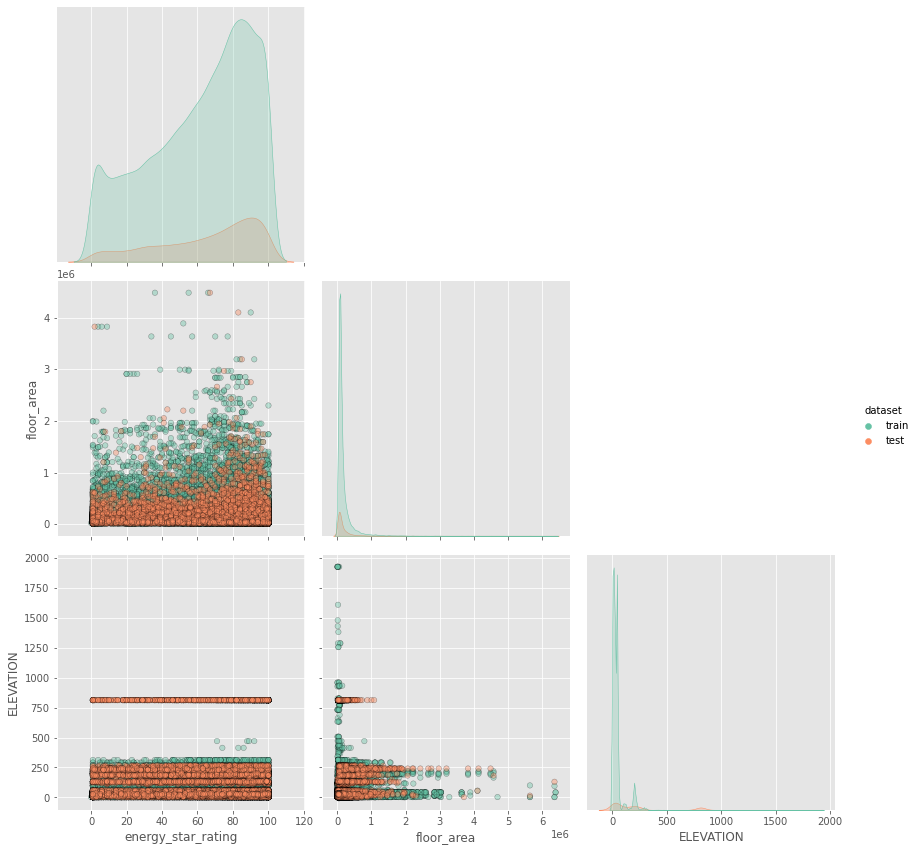

In [ ]:
sns.pairplot(df_all,
            vars=['energy_star_rating','floor_area','ELEVATION'], 
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           );

According to the average temperature (`avg_temp`), if we list states from warmest to coldest: State 1, State 10, State 2, and State 8. The range of temperatures of State1, State 6,  State 11 and State 4 are higher compared to the other states. 

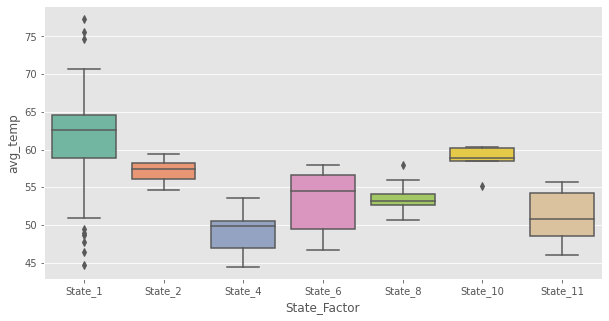

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');


# any one categorical col (with low unique vals)

Each month has unique temperature values between 31 and 59 which means the values in temperature volumes are highly repeated for the data points.

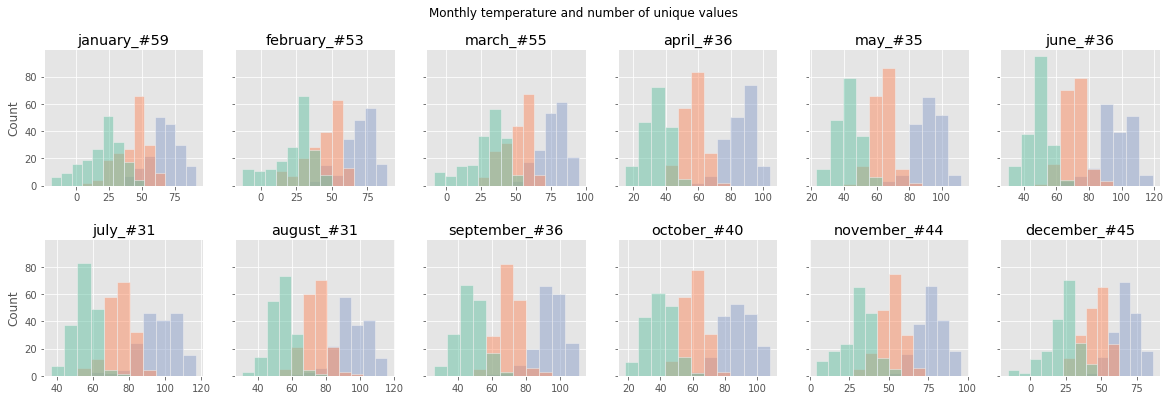

In [ ]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

Other weather related numerical columns also have few unique values.

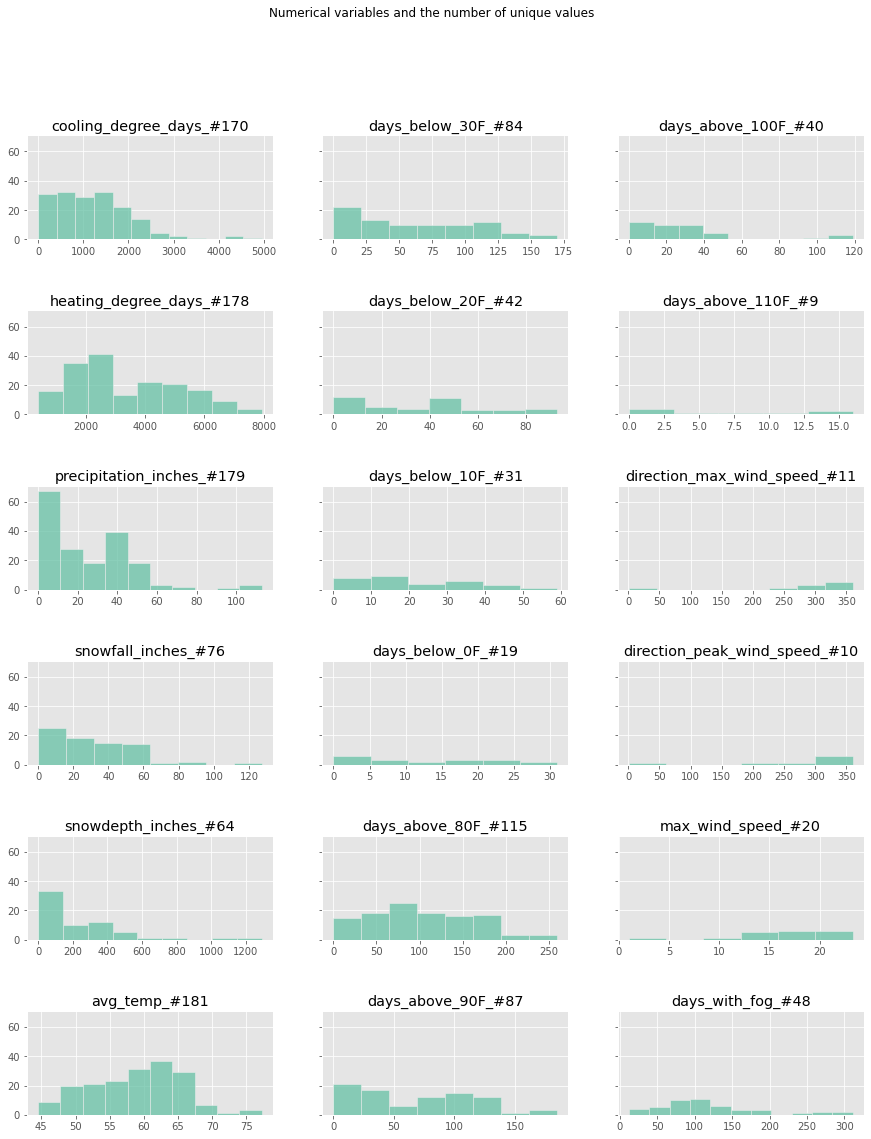

In [ ]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

### Target Variable Exploration (EUI)

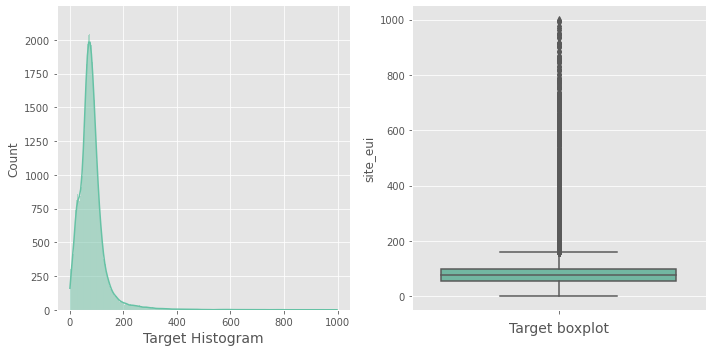

In [ ]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout();

State 2 and 4 have slightly higher EUI and State 11 and 8 have lower EUI level.

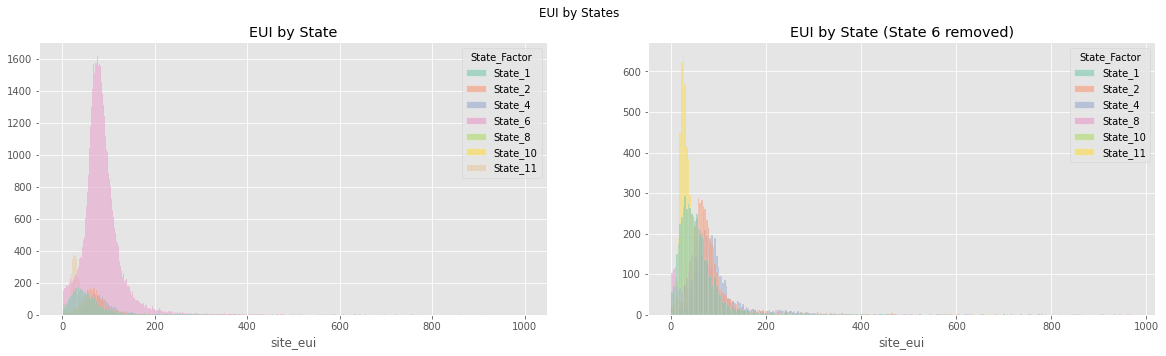

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

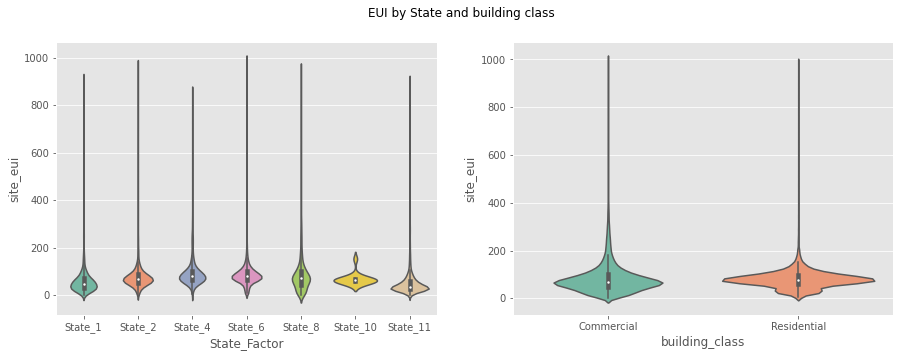

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.violinplot(data=df_all, y='site_eui', x='State_Factor', ax=ax[0])
sns.violinplot(data=df_all, y='site_eui', x='building_class', ax=ax[1]);

Labs and Data Centers have higher EUI compared to the other types of buildings. Grocery stores, Health Care Inpatient, Health Care Uncategorized, Health Care Outpatient, and Food service, restaurants have higher range of EUI. It could be the essential services must operate for longer hours, therefore, have higher EUI.

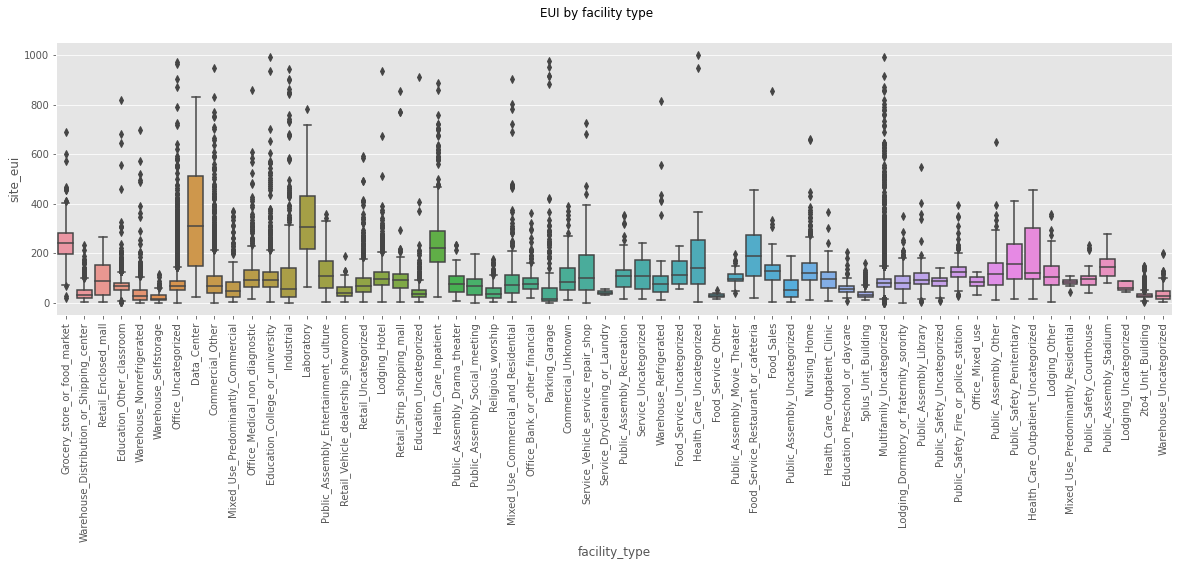

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

`floor_area` could have positive relationship with `EUI`. The younger buildings tend to have higher `EUI` which could be because building height and size have increased over the years. It looks like the Higher the `energy_star_rating` is, the lower the `EUI` becomes.

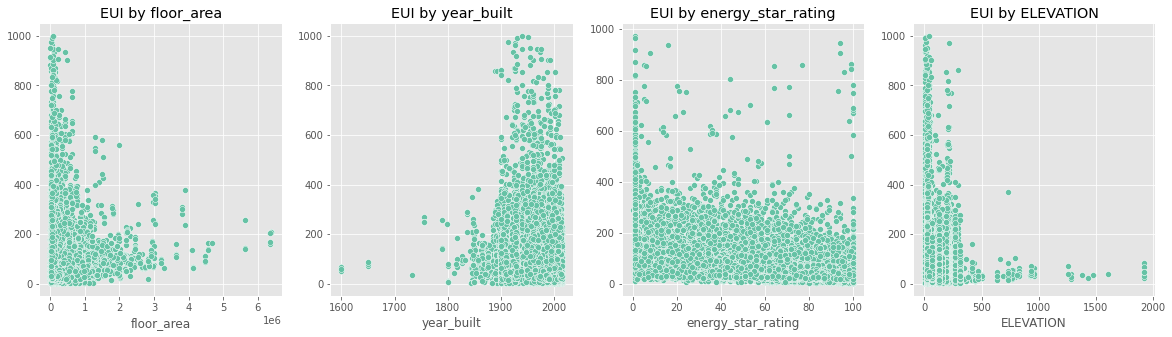

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

The most data points are in lower number of `cooling_degree_days` and higher number of`heating_degree_days`. The majority of the datapoints are also in the lower levels of `snowfall_inches` and `snowdepth_inches`. `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, and `days_with_fog` columns have the `NA` values of over 50%. No relationship between `EUI` and the weather related numerica columns can be observed from the plot.

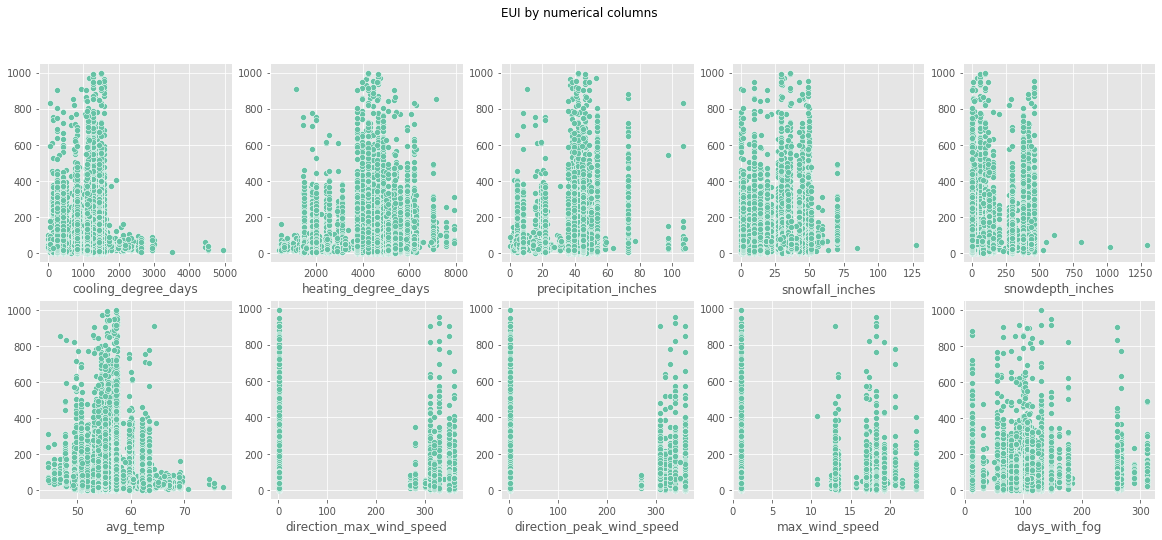

In [ ]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);

### Observations

- Categorical variables such as `State_Factor`, `building_class` and `facility_type` might have some correlation with `EUI`.
- `State_6` is not present in `test` set. State 6 removed training data should be tested.
- `floor_area`, `energe_star_rating` should be included in the modelling to be tested.
- From the plots, it's difficult to observe direct (linear) relationship between `EUI` and weather related variables. However, this doesn't deny non-linear relationships among the variables.
- Variables with more than 50% `NA` values should not be imputed (in my opinion) and better to be not included in the training set.
- Weather variables have few unique values repeated throughout the datapoints. Not sure how this duplicated values might affect the modeling and prediction.

# Preprocessing

Supposing that if two buildings have the same values for these features;   
they are the same building, in other words groupby_cols = (building_id)


Removing duplicates by clubbing similar building data

In [ ]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [ ]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

Null imputation for categorical values: **KNN Imputing**



In [ ]:
cats = ['State_Factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(df_all[col], dummy_na=False)
    for ohe_col in dummies:
        df_all[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [ ]:
df_all

Year_Factor State_Factor building_class              facility_type  \
0                3      State_1     Commercial           Commercial_Other   
1                4      State_1     Commercial           Commercial_Other   
2                5      State_1     Commercial           Commercial_Other   
3                7      State_1     Commercial           Commercial_Other   
4                3      State_1     Commercial           Commercial_Other   
...            ...          ...            ...                        ...   
85457            7      State_8    Residential  Multifamily_Uncategorized   
85458            6      State_8    Residential  Multifamily_Uncategorized   
85459            7      State_8    Residential  Multifamily_Uncategorized   
85460            6      State_8    Residential  Multifamily_Uncategorized   
85461            7      State_8    Residential  Multifamily_Uncategorized   

       floor_area  year_built  energy_star_rating  ELEVATION  \
0         10149.0      1931.0                 NaN       45.7   
1         10149.0      1931.0                 NaN      120.4   
2         10149.0      1931.0                 NaN       59.1   
3         10149.0      1931.0                 NaN       59.1   
4         10755.0      1937.0                 NaN        9.1   
...           ...         ...                 ...        ...   
85457    900000.0      1960.0                90.0      130.8   
85458   1179072.0      1959.0                96.0        3.0   
85459   1179072.0      1959.0                92.0      130.8   
85460   1195034.0      1964.0                75.0        3.0   
85461   1195034.0      1964.0                77.0      130.8   

       january_min_temp  january_avg_temp  january_max_temp  \
0                    26         44.516129                64   
1                    41         55.096774                73   
2                    29         51.387097                77   
3                    38         50.596774                64   
4                    22         44.790323                65   
...                 ...               ...               ...   
85457                 2         33.435484                61   
85458                 8         29.827586                62   
85459                 2         33.435484                61   
85460                 8         29.827586                62   
85461                 2         33.435484                61   

       february_min_temp  february_avg_temp  february_max_temp  \
0                     30          49.392857                 69   
1                     42          54.875000                 71   
2                     36          56.803571                 75   
3                     40          54.482143                 66   
4                     25          47.892857                 71   
...                  ...                ...                ...   
85457                 16          37.660714                 73   
85458                  4          33.896552                 62   
85459                 16          37.660714                 73   
85460                  4          33.896552                 62   
85461                 16          37.660714                 73   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                  37       55.967742              77              40   
1                  47       59.032258              76              47   
2                  40       61.435484              85              41   
3                  42       56.935484              77              45   
4                  32       53.112903              79              34   
...               ...             ...             ...             ...   
85457               8       35.935484              69              28   
85458              24       45.967742              79              18   
85459               8       35.935484              69              28   
85460              24       45.96

In [ ]:
# This takes 1 hr, hence, unpickle the df1 and carry on with knn_imputing = False
knn_imputing = False
target='site_eui'
#train_dataset.csv
if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    
    tmp.to_csv('/content/imputer_tmp.csv', index=False)
    df1.to_csv('/content/imputer_df1.csv', index=False)
    joblib.dump(imputer, 'models/knn_imputer.pkl')

else:
    df1 = pd.read_csv('/content/imputer_df1.csv')
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]

**Target encoding** for categorical columns.  
Target encoding is the process of replacing a categorical value with the mean of the target variable. Any non-categorical columns are automatically dropped by the target encoder model.

Note: You can also use target encoding to convert categorical columns to numeric. 

> “features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.”

[Target Encoding Vs. One-hot Encoding with Simple Examples](https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64)


In [ ]:
cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all[f'te_{col}'] = encoder.fit_transform(df_all[col], df_all[target])

# Feature Engineering

### Weather based features

we will extract new weather statistics from the building location weather features

In [ ]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all.columns if 'temp' in col]

df_all['min_temp'] = df_all[temp].min(axis=1)
df_all['max_temp'] = df_all[temp].max(axis=1)
df_all['avg_temp'] = df_all[temp].mean(axis=1)
df_all['std_temp'] = df_all[temp].std(axis=1)
df_all['skew_temp'] = df_all[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in df_all.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all['min_winter_temp'] = df_all[winter_temp].min(axis=1)
df_all['max_winter_temp'] = df_all[winter_temp].max(axis=1)
df_all['avg_winter_temp'] = df_all[winter_temp].mean(axis=1)
df_all['std_winter_temp'] = df_all[winter_temp].std(axis=1)
df_all['skew_winter_temp'] = df_all[winter_temp].skew(axis=1)
### spring
df_all['min_spring_temp'] = df_all[spring_temp].min(axis=1)
df_all['max_spring_temp'] = df_all[spring_temp].max(axis=1)
df_all['avg_spring_temp'] = df_all[spring_temp].mean(axis=1)
df_all['std_spring_temp'] = df_all[spring_temp].std(axis=1)
df_all['skew_spring_temp'] = df_all[spring_temp].skew(axis=1)
### summer
df_all['min_summer_temp'] = df_all[summer_temp].min(axis=1)
df_all['max_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['avg_summer_temp'] = df_all[summer_temp].mean(axis=1)
df_all['std_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['skew_summer_temp'] = df_all[summer_temp].max(axis=1)
## autumn
df_all['min_autumn_temp'] = df_all[autumn_temp].min(axis=1)
df_all['max_autumn_temp'] = df_all[autumn_temp].max(axis=1)
df_all['avg_autumn_temp'] = df_all[autumn_temp].mean(axis=1)
df_all['std_autumn_temp'] = df_all[autumn_temp].std(axis=1)
df_all['skew_autumn_temp'] = df_all[autumn_temp].skew(axis=1)

In [ ]:
df_all['month_cooling_degree_days'] = df_all['cooling_degree_days']/12
df_all['month_heating_degree_days'] = df_all['heating_degree_days']/12

### Buildig based feature:

we will extract building statistics

In [ ]:
# total area
df_all['building_area'] = df_all['floor_area'] * df_all['ELEVATION']
# rating energy by floor
df_all['floor_energy_star_rating'] = df_all['energy_star_rating']/df_all['ELEVATION']

### Checking target variable transformation

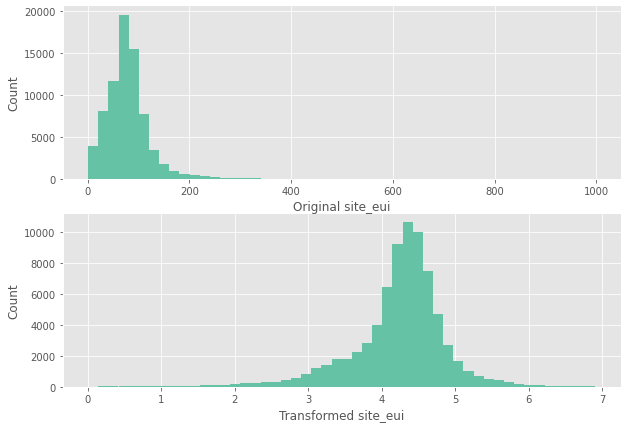

In [ ]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

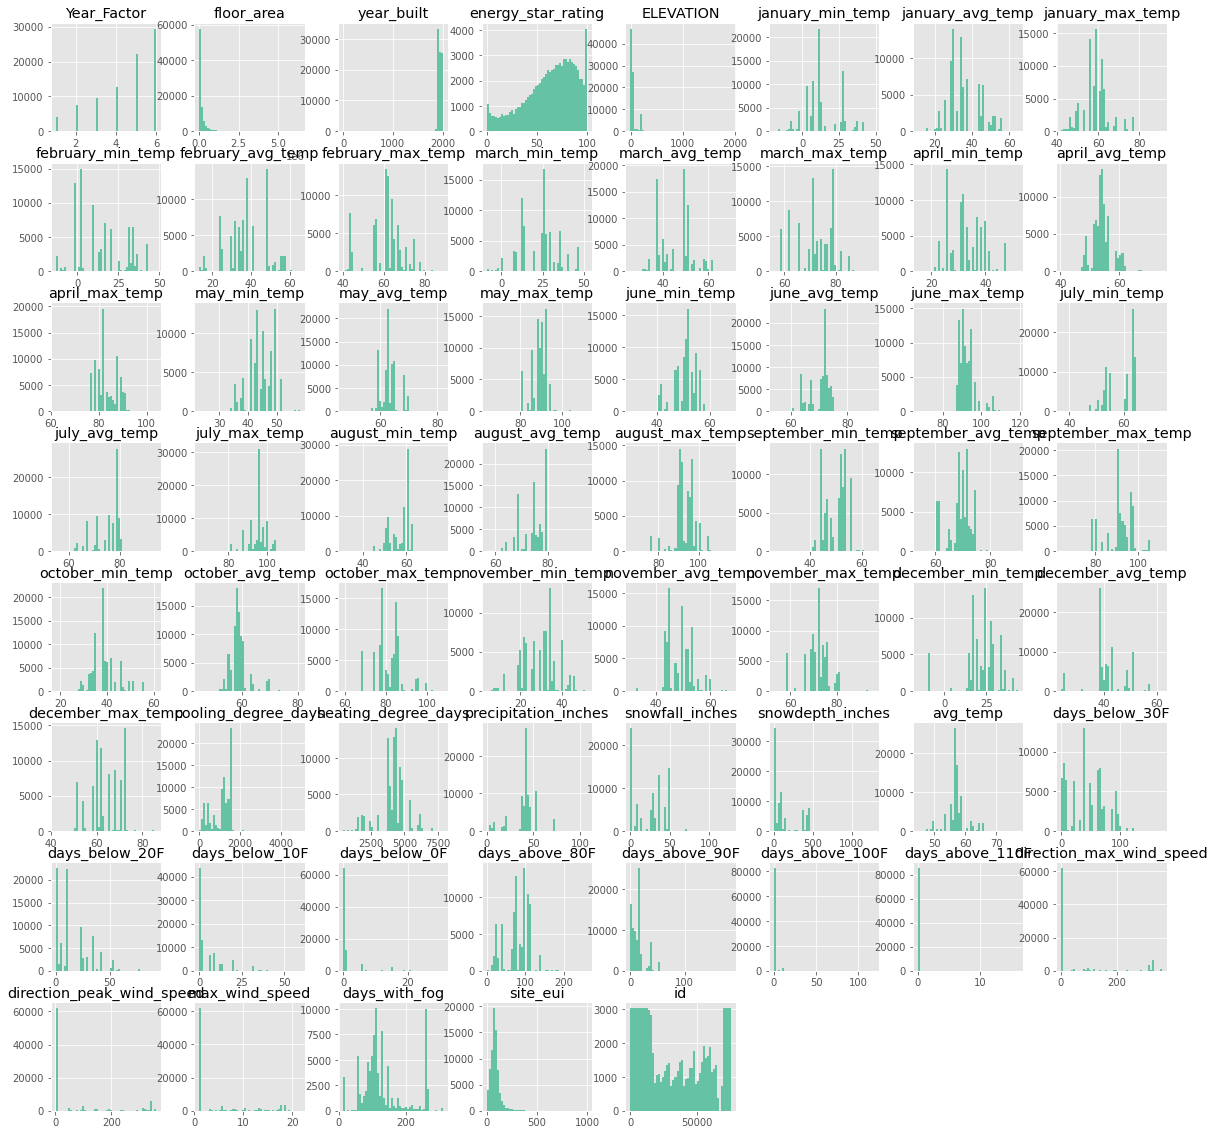

In [ ]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [ ]:
df_all[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    63.541045
days_above_100F    17.751439
year_built        -14.460703
ELEVATION           6.473239
floor_area          5.889513
dtype: float64

Binarize very skewed variables

In [ ]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all[var] = np.where(df_all[var]==0, 0, 1)

### Saving feature dataset

In [ ]:
saved = False
if saved:
    !pip install pickle5 --quiet
    import pickle5 as pickle
    data_path = 'feature_transformed_set.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    df_all.to_pickle('feature_transformed_set.pkl')

In [ ]:
df_all.shape

(85462, 165)

In [ ]:
df_all.head()

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0          3.0     10149.0      1931.0           24.000000       45.7   
1          3.0     10149.0      1931.0           24.000000       45.7   
2          4.0     10149.0      1931.0           28.285714      120.4   
3          4.0     10149.0      1931.0           28.285714      120.4   
4          5.0     10149.0      1931.0           29.142857       59.1   

   january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
0              26.0         44.516129              64.0               30.0   
1              26.0         44.516129              64.0               30.0   
2              41.0         55.096774              73.0               42.0   
3              41.0         55.096774              73.0               42.0   
4              29.0         51.387097              77.0               36.0   

   february_avg_temp  february_max_temp  march_min_temp  march_avg_temp  \
0          49.392857               69.0            37.0       55.967742   
1          49.392857               69.0            37.0       55.967742   
2          54.875000               71.0            47.0       59.032258   
3          54.875000               71.0            47.0       59.032258   
4          56.803571               75.0            40.0       61.435484   

   march_max_temp  april_min_temp  april_avg_temp  april_max_temp  \
0            77.0            40.0       61.783333            90.0   
1            77.0            40.0       61.783333            90.0   
2            76.0            47.0       60.100000            90.0   
3            76.0            47.0       60.100000            90.0   
4            85.0            41.0       60.966667            91.0   

   may_min_temp  may_avg_temp  may_max_temp  june_min_temp  june_avg_temp  \
0          45.0     65.129032          91.0           52.0      70.016667   
1          45.0     65.129032          91.0           52.0      70.016667   
2          51.0     63.483871          92.0           52.0      64.250000   
3          51.0     63.483871          92.0           52.0      64.250000   
4          45.0     62.887097          90.0           55.0      72.983333   

   june_max_temp  july_min_temp  july_avg_temp  july_max_temp  \
0          104.0           52.0      71.387097          102.0   
1          104.0           52.0      71.387097          102.0   
2           87.0           53.0      66.903226           90.0   
3           87.0           53.0      66.903226           90.0   
4          106.0           60.0      74.516129          103.0   

   august_min_temp  august_avg_temp  august_max_temp  september_min_temp  \
0             54.0        71.322581             97.0                47.0   
1             54.0        71.322581             97.0                47.0   
2             57.0        67.016129             80.0                56.0   
3             57.0        67.016129             80.0                56.0   
4             58.0        74.774194            104.0                53.0   

   september_avg_temp  september_max_temp  october_min_temp  october_avg_temp  \
0           69.133333                98.0              43.0         61.000000   
1           69.133333                98.0              43.0         61.000000   
2           68.383333                83.0              55.0         68.661290   
3           68.383333                83.0              55.0         68.661290   
4           73.583333               105.0              49.0         69.580645   

   october_max_temp  ...  building_class     facility_type  dataset  \
0              84.0  ...      Commercial  Commercial_Other    train   
1              84.0  ...      Commercial  Commercial_Other    train   
2              95.0  ...      Commercial  Commercial_Other    train   
3              95.0  ...      Commercial  Commercial_Other     test   
4              96.0  ...      Commercial  Commercial_Other    train   

    

# Baseline Modeling

In [ ]:
cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']

# typecasting numerical features
for col in df_all.drop(columns=cats + ['dataset', 'id', 'site_eui']).columns:
    df_all[col] = df_all[col].astype('float64')

In [ ]:
df_all.drop(columns=cats)

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0              3.0     10149.0      1931.0           24.000000       45.7   
1              3.0     10149.0      1931.0           24.000000       45.7   
2              4.0     10149.0      1931.0           28.285714      120.4   
3              4.0     10149.0      1931.0           28.285714      120.4   
4              5.0     10149.0      1931.0           29.142857       59.1   
...            ...         ...         ...                 ...        ...   
85457          5.0     61517.0      1961.0            5.000000        3.4   
85458          6.0     61517.0      1961.0            4.000000        3.4   
85459          6.0     61517.0      1961.0            4.000000        3.4   
85460          2.0     61528.0      1953.0           47.714286        3.4   
85461          2.0     61528.0      1953.0           47.714286        3.4   

       january_min_temp  january_avg_temp  january_max_temp  \
0                  26.0         44.516129              64.0   
1                  26.0         44.516129              64.0   
2                  41.0         55.096774              73.0   
3                  41.0         55.096774              73.0   
4                  29.0         51.387097              77.0   
...                 ...               ...               ...   
85457               8.0         29.854839              56.0   
85458              11.0         34.451613              59.0   
85459              11.0         34.451613              59.0   
85460              13.0         37.322581              62.0   
85461              13.0         37.322581              62.0   

       february_min_temp  february_avg_temp  february_max_temp  \
0                   30.0          49.392857               69.0   
1                   30.0          49.392857               69.0   
2                   42.0          54.875000               71.0   
3                   42.0          54.875000               71.0   
4                   36.0          56.803571               75.0   
...                  ...                ...                ...   
85457                2.0          23.946429               43.0   
85458               -1.0          37.706897               61.0   
85459               -1.0          37.706897               61.0   
85460               20.0          40.879310               62.0   
85461               20.0          40.879310               62.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                37.0       55.967742            77.0            40.0   
1                37.0       55.967742            77.0            40.0   
2                47.0       59.032258            76.0            47.0   
3                47.0       59.032258            76.0            47.0   
4                40.0       61.435484            85.0            41.0   
...               ...             ...             ...             ...   
85457            12.0       38.096774            62.0            32.0   
85458            26.0       48.870968            79.0            26.0   
85459            26.0       48.870968            79.0            26.0   
85460            25.0       50.935484            78.0            38.0   
85461            25.0       50.935484            78.0            38.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
0           61.783333            90.0          45.0     65.129032   
1           61.783333            90.0          45.0     65.129032   
2           60.100000            90.0          51.0     63.483871   
3           60.100000            90.0          51.0     63.483871   
4           60.966667            91.0          45.0     62.887097   
...               ...             ...           ...           ...   
85457       54.250000            80.0          48.0     68.516129   
85458       53.333333            82.0          43.0     62.790323   
85459       53.333333            8

In [ ]:
train = df_all[df_all['dataset']=='train']
test = df_all[df_all['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

### Label Encoding discrete features

In [ ]:
# get discrete end categorical features colums indexes 
# needed later for the cat bosst model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]
# create the label
le = LabelEncoder()
for col_idx in cats_discrete_idx:
    train.iloc[:, col_idx] = le.fit_transform(train.iloc[:, col_idx].astype(str))
    test.iloc[:, col_idx] = le.transform(test.iloc[:, col_idx].astype(str))

In [ ]:
print("Label Encoded Columns:")
for i in cats_discrete_idx:
    print(train.columns[i])

Label Encoded Columns:
days_above_100F
days_above_110F
State_Factor
building_class
facility_type


In [ ]:
y_test = pd.read_csv('y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 162)
Test: (9705, 162)
Samples:  (75757,)
Targets:  (9705,)


### Catboost

In [ ]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)

In [ ]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 57.9865657	test: 61.1952513	best: 61.1952513 (0)	total: 703ms	remaining: 5m 50s
75:	learn: 50.2523355	test: 67.8860263	best: 61.1952513 (0)	total: 49.3s	remaining: 4m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 61.19525134
bestIteration = 0

Shrink model to first 1 iterations.


In [ ]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 61.19525136612635
 MAE: 40.2936188319997
 MSE: 3744.858789763389
 R2: -0.03572809724179549


### XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

[17:35:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 73.71072102583956
 MAE: 48.003714111328705
 MSE: 5433.270394149145
 R2: -0.5026977312241538


### RandomForest

In [ ]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [ ]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 73.71072102583956
 MAE: 48.003714111328705
 MSE: 5433.270394149145
 R2: -0.5026977312241538


# Model Evaluation

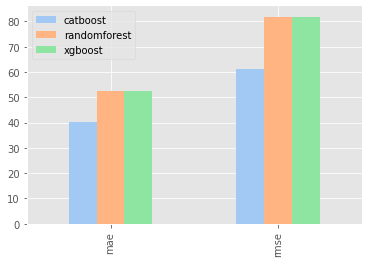

In [ ]:
error_rec = {
    "catboost": {
        "mae": 40.29268484855883,
        "rmse": 61.19378120765249,
    },
    "randomforest": {
        "mae": 52.41012420250038,
        "rmse": 81.8514058171361,
    },
    "xgboost": {
        "mae": 52.41012420250038,
        "rmse": 81.8514058171361,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

# Hyperparameter Tuning

### Using CrossValidation on CatBoost

In [ ]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits=5, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 58.2050893	test: 57.1526240	best: 57.1526240 (0)	total: 1.55s	remaining: 12m 53s
75:	learn: 50.4861802	test: 50.0090602	best: 50.0090602 (75)	total: 47.9s	remaining: 4m 26s
150:	learn: 48.5463595	test: 48.9910541	best: 48.9910541 (150)	total: 1m 30s	remaining: 3m 29s
225:	learn: 47.5351339	test: 48.6262061	best: 48.6262061 (225)	total: 2m 14s	remaining: 2m 43s
300:	learn: 46.9097084	test: 48.4400510	best: 48.4400510 (300)	total: 2m 56s	remaining: 1m 56s
375:	learn: 46.3382847	test: 48.3002135	best: 48.3000334 (372)	total: 3m 38s	remaining: 1m 12s
450:	learn: 45.8185994	test: 48.1780228	best: 48.1780228 (450)	total: 4m 22s	remaining: 28.5s
499:	learn: 45.5455052	test: 48.1151025	best: 48.1151025 (499)	total: 4m 50s	remaining: 0us

bestTest = 48.1151025
bestIteration = 499



1it [04:53, 293.05s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.936505061965541


0:	learn: 58.0965749	test: 57.5621197	best: 57.5621197 (0)	total: 598ms	remaining: 4m 58s
75:	learn: 50.3503924	test: 50.7608187	best: 50.7608187 (75)	total: 43.5s	remaining: 4m 2s
150:	learn: 48.5155846	test: 49.8547338	best: 49.8547338 (150)	total: 1m 26s	remaining: 3m 20s
225:	learn: 47.4515796	test: 49.5025344	best: 49.5025344 (225)	total: 2m 11s	remaining: 2m 39s
300:	learn: 46.6922982	test: 49.2993504	best: 49.2993504 (300)	total: 2m 54s	remaining: 1m 55s
375:	learn: 46.0737246	test: 49.1590923	best: 49.1590923 (375)	total: 3m 40s	remaining: 1m 12s
450:	learn: 45.5457532	test: 49.0531681	best: 49.0531681 (450)	total: 4m 21s	remaining: 28.5s
499:	learn: 45.2135605	test: 48.9821311	best: 48.9821311 (499)	total: 4m 49s	remaining: 0us

bestTest = 48.98213114
bestIteration = 499



2it [09:43, 291.69s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.998723535419084


0:	learn: 57.8116523	test: 58.6939525	best: 58.6939525 (0)	total: 587ms	remaining: 4m 52s
75:	learn: 49.8767745	test: 51.9532502	best: 51.9532502 (75)	total: 42.4s	remaining: 3m 56s
150:	learn: 47.9790066	test: 51.0586653	best: 51.0586653 (150)	total: 1m 26s	remaining: 3m 19s
225:	learn: 46.9142567	test: 50.7533736	best: 50.7533736 (225)	total: 2m 8s	remaining: 2m 35s
300:	learn: 46.1559840	test: 50.5798660	best: 50.5798660 (300)	total: 2m 50s	remaining: 1m 52s
375:	learn: 45.5424102	test: 50.4679018	best: 50.4679018 (375)	total: 3m 33s	remaining: 1m 10s
450:	learn: 45.0372974	test: 50.3649099	best: 50.3649099 (450)	total: 4m 14s	remaining: 27.7s
499:	learn: 44.6995920	test: 50.3092838	best: 50.3092838 (499)	total: 4m 42s	remaining: 0us

bestTest = 50.30928375
bestIteration = 499



3it [14:27, 288.02s/it]

out-of-folds prdiction ==== fold_2 RMSE 7.0929037683147715


0:	learn: 58.6060365	test: 55.4866615	best: 55.4866615 (0)	total: 592ms	remaining: 4m 55s
75:	learn: 50.7529434	test: 48.8000117	best: 48.8000117 (75)	total: 44.6s	remaining: 4m 9s
150:	learn: 48.8999051	test: 48.0284452	best: 48.0284452 (150)	total: 1m 27s	remaining: 3m 21s
225:	learn: 47.8433962	test: 47.7312853	best: 47.7312853 (225)	total: 2m 9s	remaining: 2m 37s
300:	learn: 47.2074697	test: 47.5791549	best: 47.5791549 (300)	total: 2m 53s	remaining: 1m 55s
375:	learn: 46.6522738	test: 47.4646550	best: 47.4639904 (372)	total: 3m 35s	remaining: 1m 11s
450:	learn: 46.1870967	test: 47.3850545	best: 47.3850545 (450)	total: 4m 16s	remaining: 27.9s
499:	learn: 45.9016705	test: 47.3485845	best: 47.3456641 (494)	total: 4m 45s	remaining: 0us

bestTest = 47.34566411
bestIteration = 494

Shrink model to first 495 iterations.


4it [19:14, 287.61s/it]

out-of-folds prdiction ==== fold_3 RMSE 6.88081856307334


0:	learn: 57.2332318	test: 60.9531520	best: 60.9531520 (0)	total: 581ms	remaining: 4m 50s
75:	learn: 49.6689689	test: 53.3046741	best: 53.3046741 (75)	total: 43.4s	remaining: 4m 2s
150:	learn: 47.9948873	test: 52.1226108	best: 52.1226108 (150)	total: 1m 25s	remaining: 3m 18s
225:	learn: 47.0427866	test: 51.5975722	best: 51.5975722 (225)	total: 2m 10s	remaining: 2m 37s
300:	learn: 46.4392993	test: 51.3329505	best: 51.3329505 (300)	total: 2m 50s	remaining: 1m 52s
375:	learn: 45.9689048	test: 51.1726210	best: 51.1726210 (375)	total: 3m 31s	remaining: 1m 9s
450:	learn: 45.5944194	test: 51.0557851	best: 51.0557851 (450)	total: 4m 13s	remaining: 27.6s
499:	learn: 45.3337864	test: 50.9599936	best: 50.9599936 (499)	total: 4m 40s	remaining: 0us

bestTest = 50.95999364
bestIteration = 499



5it [23:56, 287.23s/it]

out-of-folds prdiction ==== fold_4 RMSE 7.138626867254875


### Using Optuna with Random Forest

In [ ]:
# cross validating training data
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def random_forest_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()

In [ ]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [ ]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

[I 2022-07-26 18:16:36,890] A new study created in memory with name: no-name-f4ffda86-8cf3-4c65-a5ae-fe95e9abe554
[I 2022-07-26 18:31:11,150] Trial 0 finished with value: -49.876397959582945 and parameters: {'n_estimators': 276, 'max_depth': 5, 'min_samples_split': 7, 'max_features': 0.871974836869228}. Best is trial 0 with value: -49.876397959582945.


Best score: -49.876397959582945
Optimized parameters: {'n_estimators': 276, 'max_depth': 5, 'min_samples_split': 7, 'max_features': 0.871974836869228}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
CPU times: user 14min 35s, sys: 903 ms, total: 14min 35s
Wall time: 14min 34s


In [ ]:
rf_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=0.871974836869228,
                      min_samples_split=7, n_estimators=276)

### Final Evaluation

Text(0.5, 0, 'iteration')

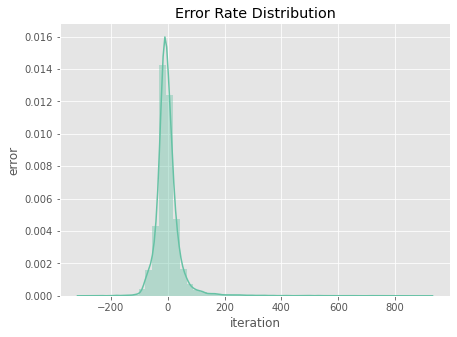

In [ ]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

Text(0.5, 0, 'iteration')

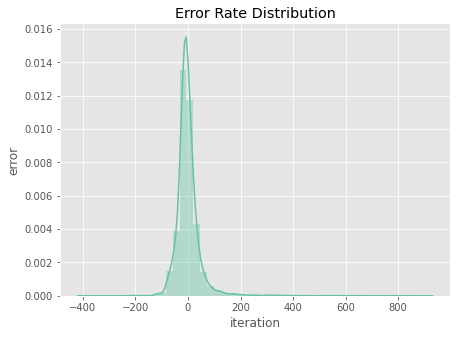

In [ ]:
y_hat_tuned = rf_tuned_model.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

### Saving Models

In [ ]:
with open('rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [ ]:
## Load models here
load = False
if load:
    with open('rf_tuned_final.joblib', 'rb') as f:
        rf = joblib.load(f)

    with open('model/catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)

# Explainable AI

pick your sample to study the model upon

In [ ]:
size = 2000

sample_exists = False

if sample_exists:
    sample_set = pd.read_csv('data/shap/sample2000.csv')
else:
    sample_set = X_test.sample(2000)
sample_set

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
69226          6.0     54419.0      1929.0            6.000000       42.7   
13756          5.0     26185.0      1959.0           90.000000       18.3   
44001          6.0     31035.0      1910.0           44.714286       42.7   
36368          6.0    168566.0      2001.0           57.857143       42.7   
26419          5.0     80028.0      1910.0           96.000000      201.8   
...            ...         ...         ...                 ...        ...   
39235          6.0    179024.0      1931.0           90.000000        3.4   
13278          5.0     22824.0      1978.0           38.000000       18.3   
66692          4.0     52000.0      1956.0           58.000000        3.4   
39303          6.0    187200.0      2002.0           46.000000        3.4   
10781          5.0     39030.0      1902.0           99.000000       18.3   

       january_min_temp  january_avg_temp  january_max_temp  \
69226              11.0         34.451613              59.0   
13756              28.0         45.419355              63.0   
44001              11.0         34.451613              59.0   
36368              11.0         34.451613              59.0   
26419              -8.0         21.935484              46.0   
...                 ...               ...               ...   
39235              11.0         34.451613              59.0   
13278              28.0         45.419355              63.0   
66692               4.0         28.596774              58.0   
39303              11.0         34.451613              59.0   
10781              28.0         45.419355              63.0   

       february_min_temp  february_avg_temp  february_max_temp  \
69226               -1.0          37.706897               61.0   
13756               32.0          48.321429               62.0   
44001               -1.0          37.706897               61.0   
36368               -1.0          37.706897               61.0   
26419              -13.0          15.696429               44.0   
...                  ...                ...                ...   
39235               -1.0          37.706897               61.0   
13278               32.0          48.321429               62.0   
66692                9.0          31.625000               56.0   
39303               -1.0          37.706897               61.0   
10781               32.0          48.321429               62.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
69226            26.0       48.870968            79.0            26.0   
13756            29.0       50.725806            71.0            37.0   
44001            26.0       48.870968            79.0            26.0   
36368            26.0       48.870968            79.0            26.0   
26419             0.0       34.161290            72.0            27.0   
...               ...             ...             ...             ...   
39235            26.0       48.870968            79.0            26.0   
13278            29.0       50.725806            71.0            37.0   
66692            13.0       37.661290            66.0            31.0   
39303            26.0       48.870968            79.0            26.0   
10781            29.0       50.725806            71.0            37.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
69226       53.333333            82.0          43.0     62.790323   
13756       51.850000            78.0          41.0     59.080645   
44001       53.333333            82.0          43.0     62.790323   
36368       53.333333            82.0          43.0     62.790323   
26419       48.200000            78.0          35.0     60.241935   
...               ...             ...           ...           ...   
39235       53.333333            82.0          43.0     62.790323   
13278       51.850000            78.0          41.0     59.080645   
66692       52.333333            7

calculate shap values

In [ ]:
is_saved = False

if is_saved:
    with open('shap_values_sample2000.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(catb).shap_values(sample_set)

In [ ]:
shap.initjs()

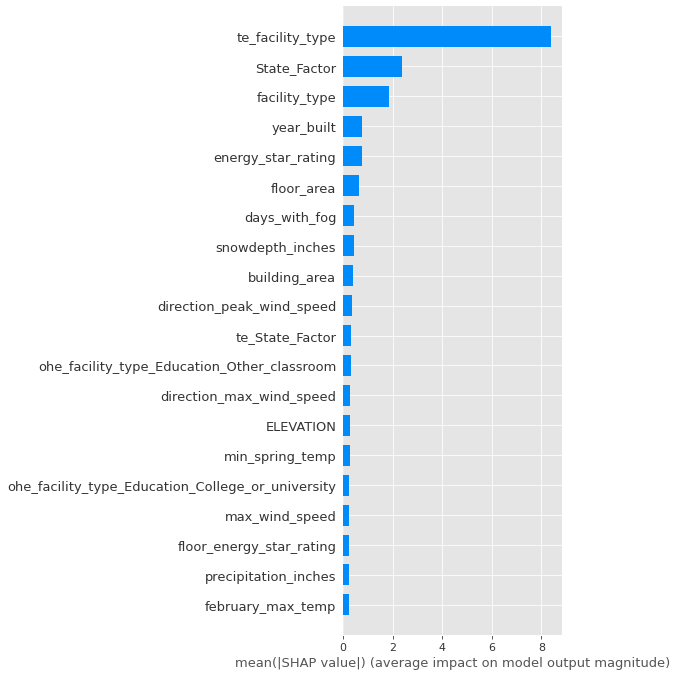

In [ ]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

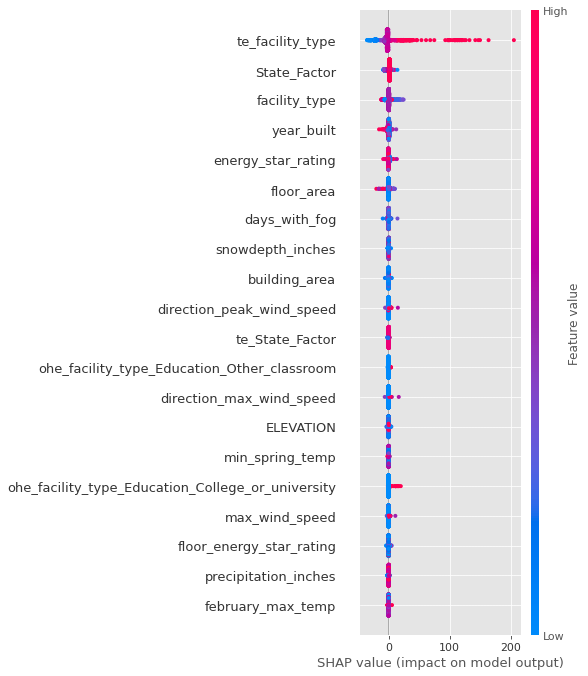

In [ ]:
shap.summary_plot(shap_values, sample_set)

In [ ]:
limit = 200
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[0:limit,:], sample_set.iloc[0:limit,:])

In [ ]:
row = 60
print(y_pred[row])
shap.initjs()
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[row], sample_set.iloc[row])

82.21574


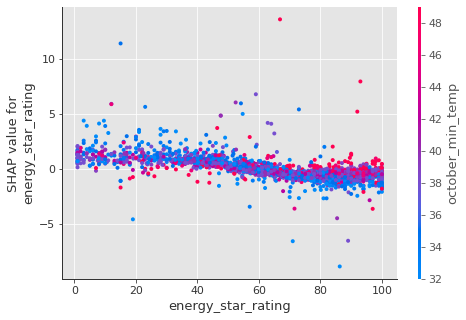

In [ ]:
shap.dependence_plot('energy_star_rating', shap_values, sample_set)

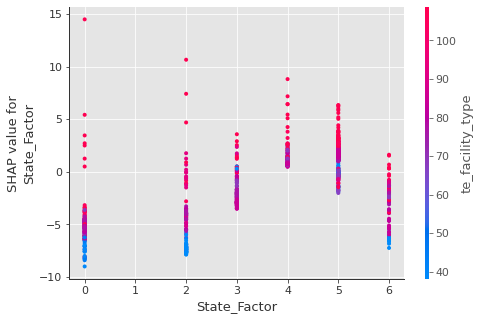

In [ ]:
shap.dependence_plot('State_Factor', shap_values, sample_set)

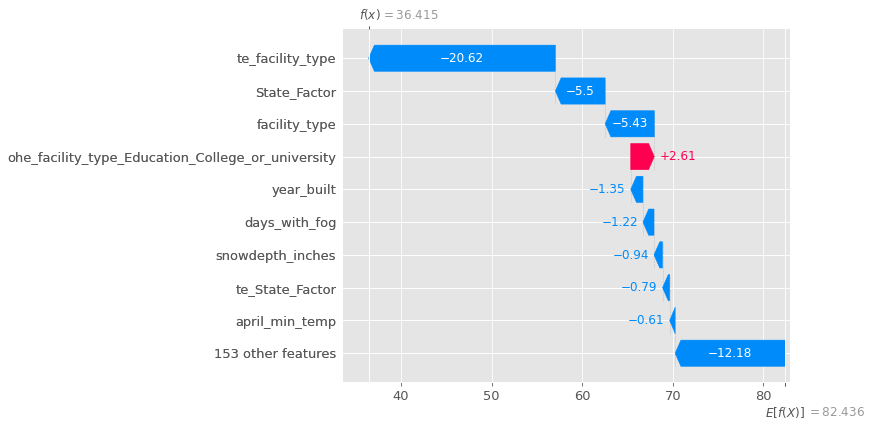

In [ ]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=sample_set.columns.tolist()
                                      )

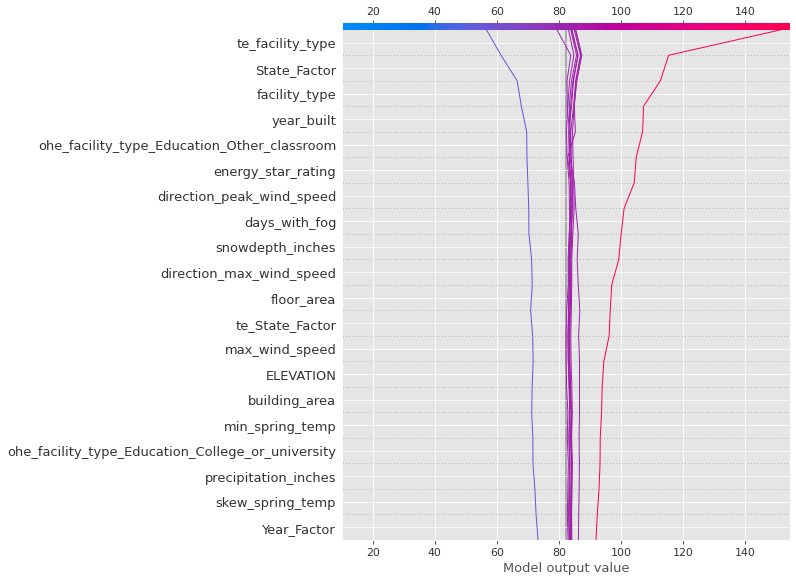

In [ ]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=sample_set.columns.tolist())

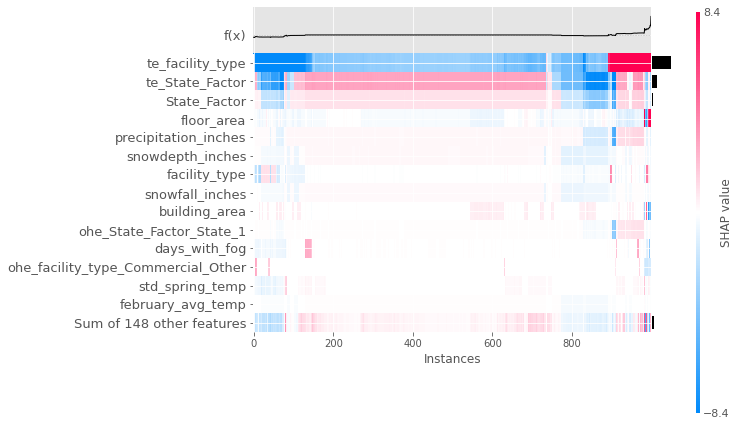

In [ ]:
limit = 1000
shap.plots.heatmap(shap.TreeExplainer(rf_tuned_model, data=sample_set)(sample_set[:limit]), max_display=15)